# GRU을 이용한 스타벅스 주가 예측

# 1 필수 라이브러리 호출

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import pandas as pd

c:\Users\SD\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2 데이터 전처리

In [2]:
data = pd.read_csv("./STBX_csv/SBUX.csv") # 스타벅스 데이터 호출

data['Date'] = pd.to_datetime(data['Date'])
data.set_index("Date", inplace=True)

data['volume'] = data['Volume'].astype(float)

x = data.iloc[:, :-2]
y = data.iloc[:, 5:6]

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

ms = MinMaxScaler()
ss = StandardScaler()

x_ss = ss.fit_transform(x)
y_ms = ms.fit_transform(y)

x_tr = x_ss[:200, :]
x_te = x_ss[200:, :]

y_tr = y_ms[:200, :]
y_te = y_ms[200:, :]

print("===================Origin Shape===================")
print(f"Train : {x_tr.shape}, {y_tr.shape}.shape")
print(f"Test : {x_te.shape}, {y_te.shape}.shape\n\n")

x_tr_tensor = torch.autograd.Variable(torch.Tensor(x_tr))
x_te_tensor = torch.autograd.Variable(torch.Tensor(x_te))
x_tr_tensor = torch.unsqueeze(x_tr_tensor, dim=1)
x_te_tensor = torch.unsqueeze(x_te_tensor, dim=1)

y_tr_tensor = torch.autograd.Variable(torch.Tensor(y_tr))
y_te_tensor = torch.autograd.Variable(torch.Tensor(y_te))
y_tr_tensor = torch.unsqueeze(y_tr_tensor, dim=1)
y_te_tensor = torch.unsqueeze(y_te_tensor, dim=1)
print("===================Tensor Shape===================")
print(f"Train : {x_tr_tensor.shape}, {y_tr_tensor.shape}.shape")
print(f"Test : {x_te_tensor.shape}, {y_te_tensor.shape}.shape")

===================Origin Shape===================
Train : (200, 5), (200, 1).shape
Test : (50, 5), (50, 1).shape


===================Tensor Shape===================
Train : torch.Size([200, 1, 5]), torch.Size([200, 1, 1]).shape
Test : torch.Size([50, 1, 5]), torch.Size([50, 1, 1]).shape


# 3 모델 클래스 생성

In [3]:
class GRU_layer(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(GRU_layer, self).__init__()
        self.num_classes = num_classes  # 클래스 갯수
        self.input_size  = input_size   # LSTM 입력 계층 갯수
        self.hidden_size = hidden_size  # 입력 데이터 크기
        self.num_layers  = num_layers   # 은닉층 뉴런 깊이
        self.seq_length  = seq_length   # 시퀀스 길이

        self.gru = nn.GRU(input_size  = input_size, 
                            hidden_size = hidden_size,
                            num_layers  = num_layers, 
                            batch_first = True)
        
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        output, hidden = self.gru(x) 
        output = output.view(-1, self.hidden_size)
        output = self.fc1(output)
        output = F.relu(output)
        output = self.fc2(output)
        return output

# 4 변수 및 모델 값 설정

In [4]:
num_epochs = 1000
lr = 0.0001

input_size  = 5 # 입력 데이터 크기  
hidden_size = 2 # 출력 데이터 크기
num_layers  = 1 # 은닉층 깊이
num_classes = 1 # 최종 출력 클래스 갯수

model = GRU_layer(num_classes, input_size, hidden_size, num_layers, x_tr_tensor.shape[1])
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

model

GRU_layer(
  (gru): GRU(5, 2, batch_first=True)
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

# 5 모델 학습

In [5]:
for epoch in range(num_epochs):
    output = model(x_tr_tensor)
    optimizer.zero_grad()
    loss = criterion(output, y_tr_tensor)
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epochs : {epoch} \t MSE loss : {loss.item():.5f}")

c:\Users\SD\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epochs : 0 	 MSE loss : 0.11494
Epochs : 100 	 MSE loss : 0.03817
Epochs : 200 	 MSE loss : 0.02281
Epochs : 300 	 MSE loss : 0.02169
Epochs : 400 	 MSE loss : 0.02160
Epochs : 500 	 MSE loss : 0.02154
Epochs : 600 	 MSE loss : 0.02150
Epochs : 700 	 MSE loss : 0.02146
Epochs : 800 	 MSE loss : 0.02143
Epochs : 900 	 MSE loss : 0.02141


# 6 예측결과 확인

In [6]:
train_predict = model(x_tr_tensor)
predicted= train_predict.data.numpy()
label_y = np.squeeze(y_tr_tensor.data.numpy(), axis=1)

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

# 7 시각화

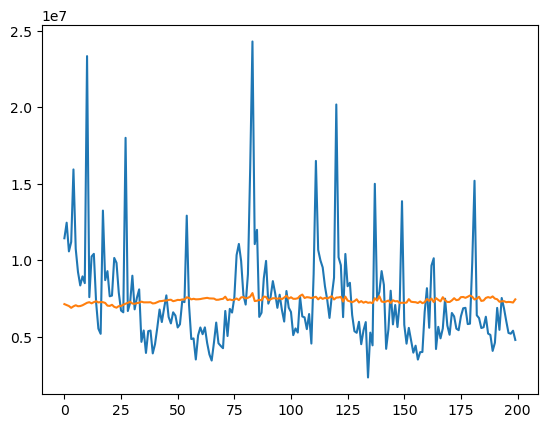

In [7]:
import matplotlib.pyplot as plt

plt.plot(label_y)
plt.plot(predicted)